## Importing data, and merging tables

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
path_to_project = '/content/gdrive/My Drive/Salary Prediction POC/datadavis-nba-salaries' # Enter the path to your folder here
os.chdir(path_to_project)

Mounted at /content/gdrive


In [2]:
import pandas as pd
players_df = pd.read_csv("players.csv")
players_df.head()

,_id,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight
0,abdelal01,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
1,abdulza01,"April 7, 1946","Brooklyn, New York",1.2,42.8,NaN,72.8,505,15.1,9.0,8.0,17.5,NaN,Iowa State University,5th overall,1st round,Cincinnati Royals,1968,6-9,"John Jay in Brooklyn, New York",Zaid Abdul-Aziz,Power Forward and Center,Right,235lb
2,abdulka01,"April 16, 1947","New York, New York",3.6,55.9,5.6,72.1,1560,24.6,24.6,11.2,273.4,55.9,"University of California, Los Angeles",1st overall,1st round,Milwaukee Bucks,1969,7-2,"Power Memorial in New York, New York",Kareem Abdul-Jabbar,Center,Right,225lb
3,abdulma02,"March 9, 1969","Gulfport, Mississippi",3.5,44.2,35.4,90.5,586,15.4,14.6,1.9,25.2,47.2,Louisiana State University,3rd overall,1st round,Denver Nuggets,1990,6-1,"Gulfport in Gulfport, Mississippi",Mahmoud Abdul-Rauf,Point Guard,Right,162lb
4,abdulta01,"November 3, 1974","Maisons Alfort, France",1.1,41.7,23.7,70.3,236,11.4,7.8,3.3,3.5,42.2,"University of Michigan, San Jose State University",11th overall,1st round,Sacramento Kings,1997,6-6,"Lycee Aristide Briand in Evreux, France",Tariq Abdul-Wahad,Shooting Guard,Right,223lb


In [3]:
salaries_df = pd.read_csv("salaries_1985to2018.csv")
salaries_df

,league,player_id,salary,season,season_end,season_start,team
0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers
1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers
2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics
3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics
4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings
...,...,...,...,...,...,...,...
14158,NBA,zipsepa01,750000,2016-17,2017,2016,Chicago Bulls
14159,NBA,zipsepa01,1312611,2017-18,2018,2017,Chicago Bulls
14160,NBA,zizican01,1645200,2017-18,2018,2017,Cleveland Cavaliers
14161,NBA,zubaciv01,1034956,2016-17,2017,2016,Los Angeles Lakers


In [4]:
## renaming the player id column in the player's dataframe to stay consistent
players_df.rename(columns = {'_id':'player_id'}, inplace = True)

In [5]:
## looking at the number of unique ids we can merge on
len_unique_players = len(players_df.player_id.unique())
len_unique_salaries = len(salaries_df.player_id.unique())
print(f"The number of unique player IDs in the players dataframe is {len_unique_players}")
print(f"The number of unique player IDs in the salaries dataframe is {len_unique_salaries}")

The number of unique player IDs in the players dataframe is 4685
The number of unique player IDs in the salaries dataframe is 2408


In [12]:
## since our salaries dataframe seems to be constraint here, we are going to inner join on salaries
player_salaries_df = pd.merge(left = salaries_df, right = players_df, how = 'inner', left_on = 'player_id', right_on = 'player_id')
player_salaries_df.head()

,league,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight
0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb


In [13]:
## we need to filter the league to the nba, let's see if other leagues exist
print(player_salaries_df.league.value_counts())

## since other leagues do not exist, this feature is not useful and can be dropped, will include a small check, so that in the future 
## if the leaugue data expands, this can be accounted for
assert(len(player_salaries_df.league.unique()) == 1)
player_salaries_df.drop(columns = ['league'], inplace = True)

NBA    14163
Name: league, dtype: int64


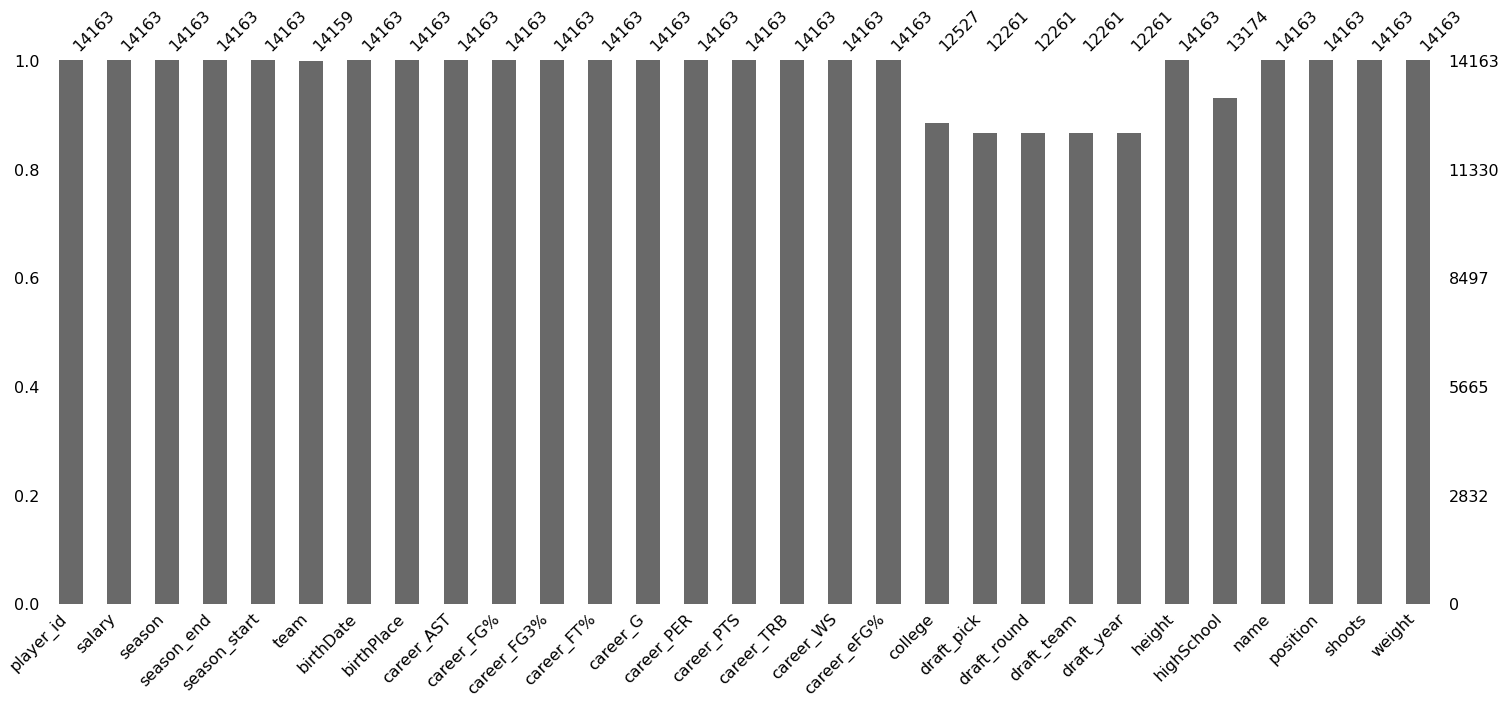

In [8]:
## since the only league is the nba, let's now visualize the missing value percentages per feature
import missingno as msno
%matplotlib inline
msno.bar(player_salaries_df)

Looks like all of our features are complete except the features of collge, draft_pick, draft_round_ draft_team, draft_year, height and highschool, and team.

A lot of the missing features seem to be draft related, so this could pertain to undrafted players, and/or players that haven't come to the nba via the traditional high-school -> NCAA, NBA path. Furthermore in 2006, then nba made a new rule that all nba players must atleast have one year of college experience (or its equivalent), so for the players pre 2006, college isn't a necessity.

Since there are only four missing team datapoints, we can either elect to drop or impute. The algorithm we are using forward called autoML does a very good job at handling missing values (via imputation), we will leave them in for now.

While the columns of season start, season end combined seem redundant with the column season, they actually do offer extra information for lockout shortened seasons, where the start of the season might have been delayed to the following year due to a lockout, we elect to keep all of them in.

In [9]:
# ## dropping missing value data pount for team
# player_salaries_df.dropna(subset=['team'], inplace = True)

In [10]:
## Let's take a look at missing draft values
## I'm also going to ignore high school, college and team for now, and focus on just draft related missing data 

player_salaries_df_no_hs = player_salaries_df.loc[:, ~player_salaries_df.columns.isin(['highSchool','college','team'])]
null_data = player_salaries_df_no_hs[player_salaries_df_no_hs.isnull().any(axis=1)]
print(f" The length of the missing value dataframe for draft values is {len(null_data)}")
null_data.head()

 The length of the missing value dataframe for draft values is 1902


,player_id,salary,season,season_end,season_start,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,draft_pick,draft_round,draft_team,draft_year,height,name,position,shoots,weight
83,adrieje01,342666,2010-11,2011,2010,"February 10, 1986","Brookline, Massachusetts",0.7,47.4,0.0,62.8,153,15.0,4.6,4.3,4.4,47.4,NaN,NaN,NaN,NaN,6-7,Jeff Adrien,Power Forward,Right,245lb
84,adrieje01,270427,2011-12,2012,2011,"February 10, 1986","Brookline, Massachusetts",0.7,47.4,0.0,62.8,153,15.0,4.6,4.3,4.4,47.4,NaN,NaN,NaN,NaN,6-7,Jeff Adrien,Power Forward,Right,245lb
85,adrieje01,804131,2012-13,2013,2012,"February 10, 1986","Brookline, Massachusetts",0.7,47.4,0.0,62.8,153,15.0,4.6,4.3,4.4,47.4,NaN,NaN,NaN,NaN,6-7,Jeff Adrien,Power Forward,Right,245lb
86,adrieje01,916099,2013-14,2014,2013,"February 10, 1986","Brookline, Massachusetts",0.7,47.4,0.0,62.8,153,15.0,4.6,4.3,4.4,47.4,NaN,NaN,NaN,NaN,6-7,Jeff Adrien,Power Forward,Right,245lb
87,adrieje01,981084,2014-15,2015,2014,"February 10, 1986","Brookline, Massachusetts",0.7,47.4,0.0,62.8,153,15.0,4.6,4.3,4.4,47.4,NaN,NaN,NaN,NaN,6-7,Jeff Adrien,Power Forward,Right,245lb


In [11]:
## now let us take a look at how many unique names in this dataframe 
print(f" The number of unique names with missing draft values are is {len(null_data.name.unique())}")
null_data.name.unique()[:5]

 The number of unique names with missing draft values are is 523


array(['Jeff Adrien', 'Blake Ahearn', 'Josh Akognon', 'Cliff Alexander',
       'Gary Alexander'], dtype=object)

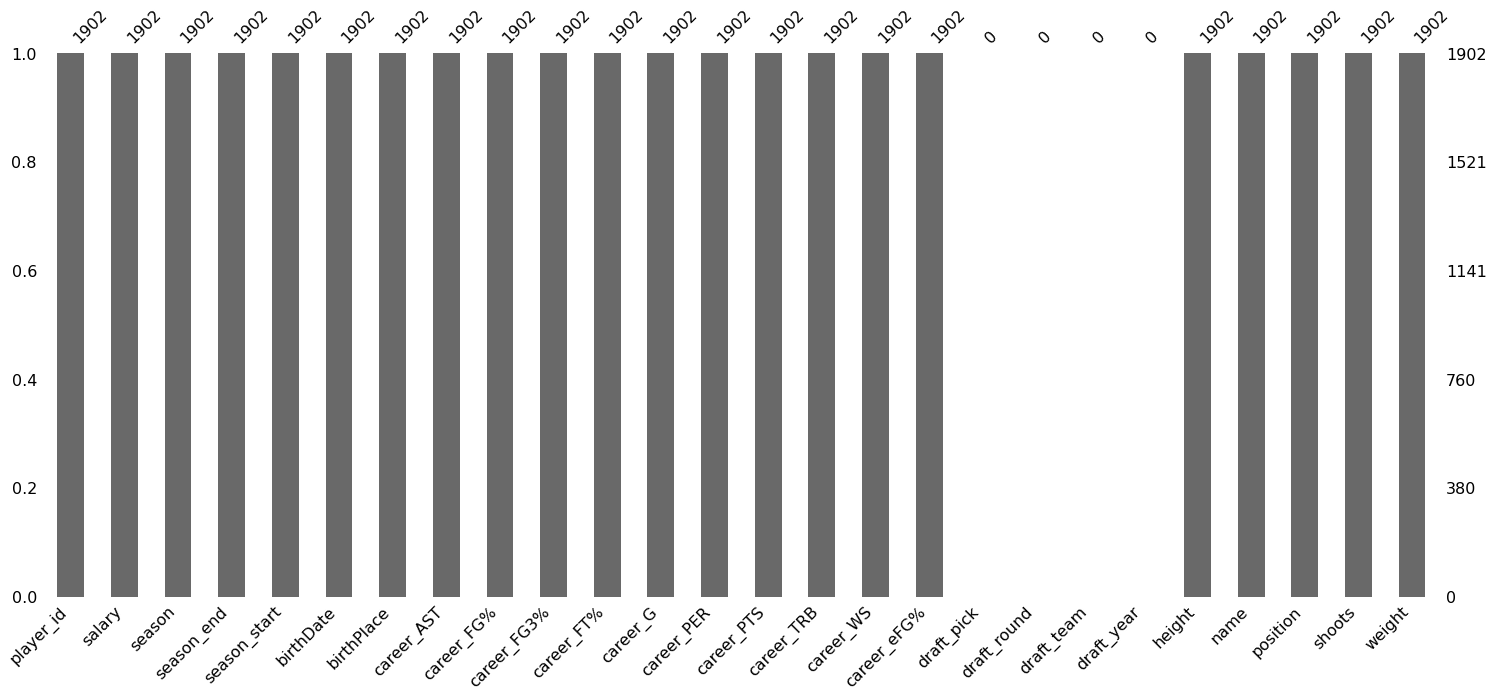

In [14]:
## Let's see whether is a mix of missing draft values or if there is an overall lack of any
msno.bar(null_data)

As we can observe all these players (all 523 of them, representing 1902 datapoints) have no draft data at all. Leading us to believe they are undrafted. A few quick google searches does indeed show that the players are undrafted, and a more robust way could be a scraper check, that if a web search leads to a select player's draft history being shown as not undrafted, then the datapoint is modified.

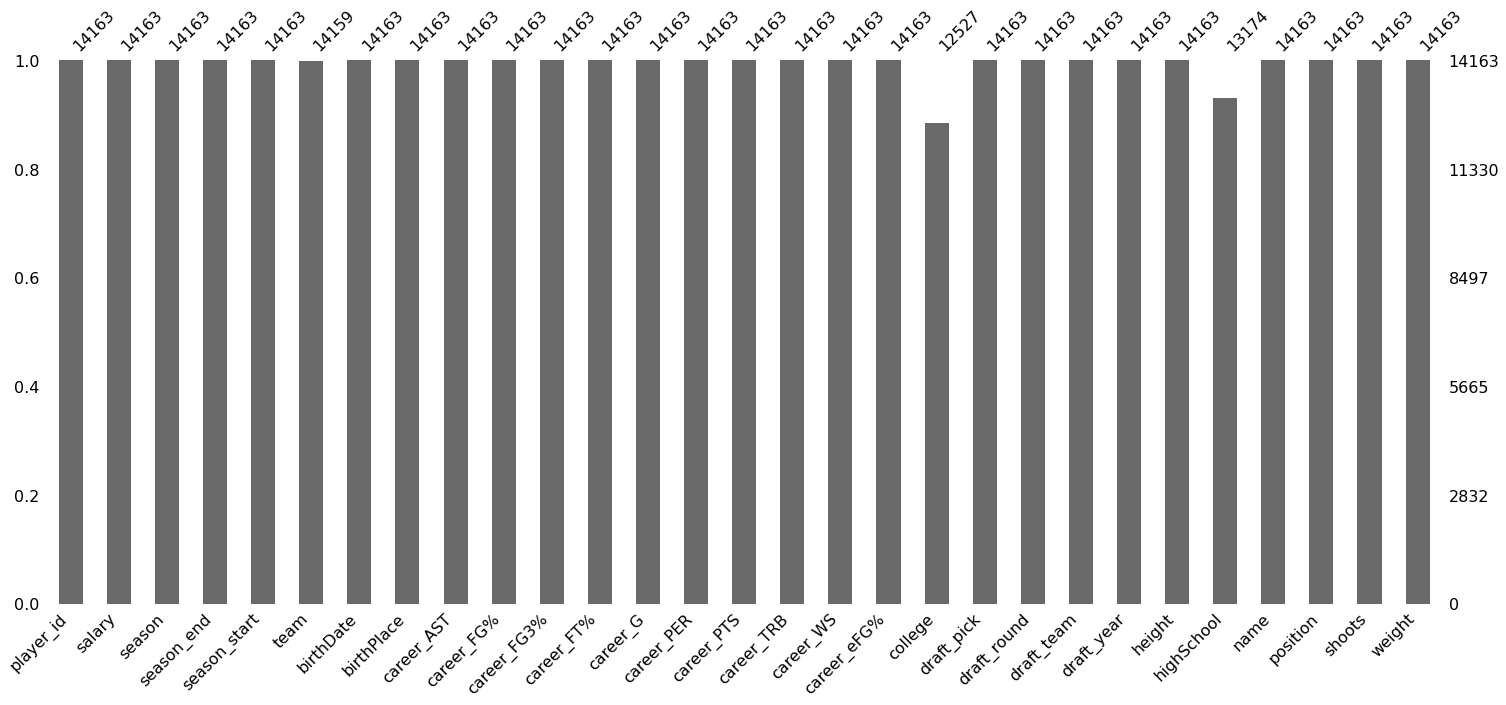

In [15]:
player_salaries_df[['draft_pick','draft_round','draft_team','draft_year']] = player_salaries_df[['draft_pick','draft_round','draft_team','draft_year']].fillna(value = "Undrafted")
msno.bar(player_salaries_df)

In [16]:
## Let's now deal with the players missing college and high school data
## Let us deal with high school data first
null_hs_data = player_salaries_df[player_salaries_df.highSchool.isnull()]
print(f" The length of the missing value dataframe for high school values is {len(null_hs_data)}")
null_hs_data.head()

 The length of the missing value dataframe for high school values is 989


,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight
39,abrinal01,5994764,2016-17,2017,2016,Oklahoma City Thunder,"August 1, 1993","Palma de Mallorca, Spain",0.5,38.7,36.8,88.0,174,8.8,5.3,1.4,5.0,52.5,NaN,32nd overall,2nd round,Oklahoma City Thunder,2013,6-6,NaN,Alex Abrines,Shooting Guard,Right,200lb
40,abrinal01,5725000,2017-18,2018,2017,Oklahoma City Thunder,"August 1, 1993","Palma de Mallorca, Spain",0.5,38.7,36.8,88.0,174,8.8,5.3,1.4,5.0,52.5,NaN,32nd overall,2nd round,Oklahoma City Thunder,2013,6-6,NaN,Alex Abrines,Shooting Guard,Right,200lb
123,ajincal01,1276320,2008-09,2009,2008,Charlotte Bobcats,"May 6, 1988","Saint-Etienne, France",0.5,50.3,28.6,79.7,293,14.9,5.3,3.9,7.5,50.7,NaN,20th overall,1st round,Charlotte Bobcats,2008,7-2,NaN,Alexis Ajinca,Power Forward and Center,Right,248lb
124,ajincal01,1372080,2009-10,2010,2009,Charlotte Bobcats,"May 6, 1988","Saint-Etienne, France",0.5,50.3,28.6,79.7,293,14.9,5.3,3.9,7.5,50.7,NaN,20th overall,1st round,Charlotte Bobcats,2008,7-2,NaN,Alexis Ajinca,Power Forward and Center,Right,248lb
125,ajincal01,1467840,2010-11,2011,2010,Toronto Raptors,"May 6, 1988","Saint-Etienne, France",0.5,50.3,28.6,79.7,293,14.9,5.3,3.9,7.5,50.7,NaN,20th overall,1st round,Charlotte Bobcats,2008,7-2,NaN,Alexis Ajinca,Power Forward and Center,Right,248lb


One thing to notice off of the head of the dataframe is that a lot of these players seem to have non US birthplaces, let's use a regex to parse the values in the birthPlace column, to the countries

In [17]:
null_hs_data['birthCountry'] = null_hs_data.birthPlace.str.extract('[^,]*,(.*)')
null_hs_data['birthCountry'] =  null_hs_data.birthCountry.str.lstrip()
player_salaries_df['birthCountry'] = player_salaries_df.birthPlace.str.extract('[^,]*,(.*)')
player_salaries_df['birthCountry'] =  player_salaries_df.birthCountry.str.lstrip()
null_hs_data.birthCountry.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


France                              75
Argentina                           72
Spain                               64
Brazil                              58
Croatia                             56
Slovenia                            51
Serbia                              51
Lithuania                           48
Turkey                              42
Bosnia and Herzegovina              40
Italy                               36
Montenegro                          31
Georgia                             26
Russia                              24
Ukraine                             24
China                               24
Democratic Republic of the Congo    20
Guadeloupe                          18
Germany                             18
Belgium                             18
Poland                              17
Switzerland                         16
Greece                              16
Israel                              15
Sweden                               9
Czech Republic           

In [18]:
## This is to ensure that we are missing no us states, we will end up discarding the birth country column, but it just for data cleaning purposes
## as we choose to filter which players are internationla based on the lack of a us state in their birth country 
player_salaries_df[player_salaries_df['birthCountry'].isna()]

,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight,birthCountry
1090,bentibe01,250000,2016-17,2017,2016,Boston Celtics,"March 29, 1995",Ghana,0.0,0.0,0.0,-,3,-17.6,0.0,0.7,-0.1,0.0,Providence College,51st overall,2nd round,Boston Celtics,2016,6-9,"St. Andrew's School in Middletown, Delaware",Ben Bentil,Power Forward,Right,235lb,NaN
1091,bentibe01,50000,2016-17,2017,2016,Indiana Pacers,"March 29, 1995",Ghana,0.0,0.0,0.0,-,3,-17.6,0.0,0.7,-0.1,0.0,Providence College,51st overall,2nd round,Boston Celtics,2016,6-9,"St. Andrew's School in Middletown, Delaware",Ben Bentil,Power Forward,Right,235lb,NaN
1092,bentibe01,31969,2016-17,2017,2016,Dallas Mavericks,"March 29, 1995",Ghana,0.0,0.0,0.0,-,3,-17.6,0.0,0.7,-0.1,0.0,Providence College,51st overall,2nd round,Boston Celtics,2016,6-9,"St. Andrew's School in Middletown, Delaware",Ben Bentil,Power Forward,Right,235lb,NaN
2983,davidko01,287500,1998-99,1999,1998,Chicago Bulls,"October 22, 1971",Hungary,0.6,44.6,0.0,81.7,109,12.5,5.0,2.8,2.5,44.6,NaN,Undrafted,Undrafted,Undrafted,Undrafted,6-9,NaN,Kornel David,Small Forward,Right,235lb,NaN
2984,davidko01,175882,1999-00,2000,1999,Chicago Bulls,"October 22, 1971",Hungary,0.6,44.6,0.0,81.7,109,12.5,5.0,2.8,2.5,44.6,NaN,Undrafted,Undrafted,Undrafted,Undrafted,6-9,NaN,Kornel David,Small Forward,Right,235lb,NaN
2985,davidko01,27059,1999-00,2000,1999,Cleveland Cavaliers,"October 22, 1971",Hungary,0.6,44.6,0.0,81.7,109,12.5,5.0,2.8,2.5,44.6,NaN,Undrafted,Undrafted,Undrafted,Undrafted,6-9,NaN,Kornel David,Small Forward,Right,235lb,NaN
2986,davidko01,498500,2000-01,2001,2000,Toronto Raptors,"October 22, 1971",Hungary,0.6,44.6,0.0,81.7,109,12.5,5.0,2.8,2.5,44.6,NaN,Undrafted,Undrafted,Undrafted,Undrafted,6-9,NaN,Kornel David,Small Forward,Right,235lb,NaN
11181,sambch01,427163,2007-08,2008,2007,Detroit Pistons,"October 22, 1984",Senegal,0.0,25.0,0.0,44.4,22,7.1,1.0,1.4,-0.1,25.0,NaN,51st overall,2nd round,Los Angeles Lakers,2006,7-1,NaN,Cheikh Samb,Center,Right,245lb,NaN
11182,sambch01,797581,2008-09,2009,2008,Los Angeles Clippers,"October 22, 1984",Senegal,0.0,25.0,0.0,44.4,22,7.1,1.0,1.4,-0.1,25.0,NaN,51st overall,2nd round,Los Angeles Lakers,2006,7-1,NaN,Cheikh Samb,Center,Right,245lb,NaN
11933,stepavl01,543000,1998-99,1999,1998,Seattle SuperSonics,"May 8, 1976",Georgia,0.3,42.5,13.3,53.6,270,12.8,4.1,4.4,5.2,42.6,NaN,27th overall,1st round,Seattle SuperSonics,1998,7-0,NaN,Vladimir Stepania,Center,Right,236lb,NaN


Looking at the value counts above, we see that the majority are international birthpalces with the exception of 12 datapoints, who are from the US states with missing high school information. For the purposes of this POC, Puerto Rico will be treated as "international". Bringing our missing highschool datapoints down to 9

In [19]:
## verifying that this is georgia the country not the state
null_hs_data[null_hs_data.birthPlace.str.contains("Georgia")]

,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight,birthCountry
9677,pachuza01,366931,2003-04,2004,2003,Orlando Magic,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9678,pachuza01,620046,2004-05,2005,2004,Milwaukee Bucks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9679,pachuza01,4000000,2005-06,2006,2005,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9680,pachuza01,4000000,2006-07,2007,2006,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9681,pachuza01,4000000,2007-08,2008,2007,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9682,pachuza01,4000000,2008-09,2009,2008,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9683,pachuza01,4750000,2009-10,2010,2009,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9684,pachuza01,4251250,2010-11,2011,2010,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9685,pachuza01,4750000,2011-12,2012,2011,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia
9686,pachuza01,5248750,2012-13,2013,2012,Atlanta Hawks,"February 10, 1984","Tbilisi, Georgia",1.3,46.9,0.0,75.1,1098,14.6,6.8,5.8,52.7,46.9,NaN,42nd overall,2nd round,Orlando Magic,2003,6-11,NaN,Zaza Pachulia,Center,Right,270lb,Georgia


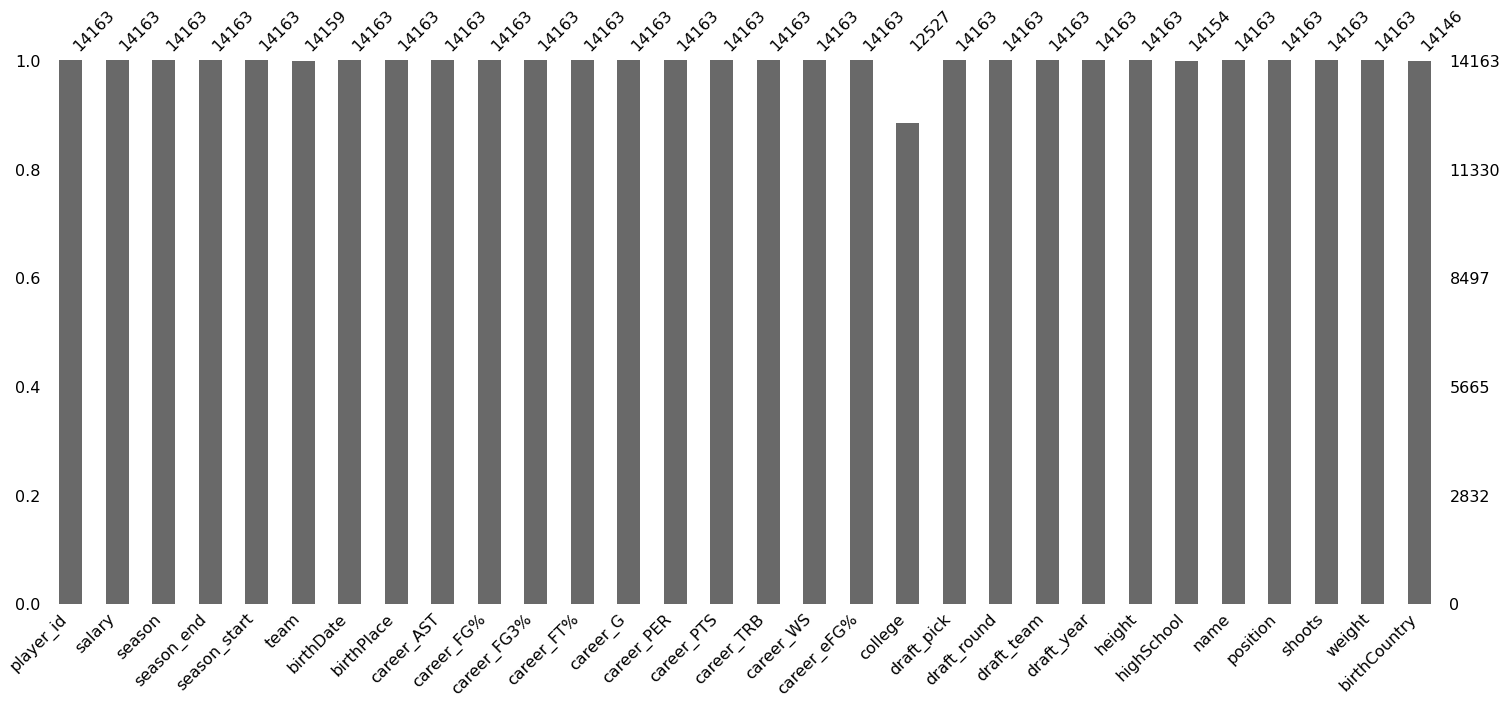

In [20]:
##filling in international for missing values of highschool for international players
us_states = ['Texas', 'Michigan', 'Oregon']
null_hs_data_non_us = null_hs_data[~null_hs_data.birthCountry.isin(us_states)]
player_salaries_df.loc[player_salaries_df.player_id.isin(list(null_hs_data_non_us.player_id.unique())),'highSchool']='International'
msno.bar(player_salaries_df)

Let us handle the missing college values

First, for all international players, let us assume that they played internationally. While some international players do come to the us for college, it is rare and this simplifies our data cleaning task as we would not need to manually verify every international player for their missing college data

Second, the nba instated a rule from the 2006 draft onwards (2005 draft highschool eligible) that players needed to be atleast one year out of high school and turn 19 during the nba season they start in. We will eventually want to replace our birthdate column with an age one, so let us do that right now. 

Their age will be measured relative to the start of the season in terms of the year. There can be no more than an error of a year (by definition), and this still gives us relatively good information.

In [21]:
null_college_data = player_salaries_df[player_salaries_df.college.isnull()]
null_college_data.birthCountry.unique()

array(['Spain', 'France', 'Turkey', 'Australia', 'Lithuania', 'Greece',
       'FYR Macedonia', 'Mexico', 'Germany', 'Brazil', 'Italy', 'China',
       'Uruguay', 'Russia', 'Guadeloupe', 'Bosnia and Herzegovina',
       'Mississippi', 'Latvia', 'Democratic Republic of the Congo',
       'Serbia', 'New York', 'Cuba', 'Slovenia', 'South Carolina',
       'Argentina', 'Pennsylvania', 'New Jersey', 'Switzerland', 'Israel',
       'California', 'Illinois', nan, 'Florida', 'Senegal', 'Montenegro',
       'United Kingdom', 'Oklahoma', 'Ukraine', 'Croatia', 'Bulgaria',
       'Poland', 'Texas', 'Islamic Republic of Iran', 'Georgia',
       'Republic of the Congo', 'French Guiana', 'Ohio', 'Sweden',
       'Alabama', 'Rhode Island', 'Louisiana', 'South Sudan', 'Virginia',
       'Tunisia', 'Romania', 'Estonia', 'Belgium', 'Nigeria',
       'Puerto Rico', 'Mali', 'Czech Republic', 'Republic of Korea',
       'Cape Verde', 'Venezuela', 'Washington', 'Tennessee', 'Kansas'],
      dtype=object)

In [22]:
us_states_missing_college = ['Mississippi', 'New York', 'South Carolina',
                            'Pennsylvania', 'New Jersey', 'California', 'Illinois', 
                            'Florida', 'Oklahoma', 'Texas', 'Ohio', 'Alabama', 
                            'Rhode Island', 'Louisiana',  'Virginia','Washington', 
                            'Tennessee', 'Kansas']

In [23]:
null_college_data_non_us = null_college_data[~null_college_data.birthCountry.isin(us_states_missing_college)]
player_salaries_df.loc[player_salaries_df.player_id.isin(list(null_college_data_non_us.player_id.unique())),'college']='International'

In [24]:
## let us check to see how many missing collge values us born players represent
null_college_data[~null_college_data.player_id.isin(list(null_college_data_non_us.player_id.unique()))].birthCountry.value_counts()

California        74
Mississippi       54
South Carolina    53
Illinois          42
New Jersey        41
Texas             40
Florida           34
New York          21
Pennsylvania      20
Louisiana         17
Ohio              15
Washington        14
Tennessee         13
Virginia          11
Rhode Island       2
Oklahoma           1
Alabama            1
Kansas             1
Name: birthCountry, dtype: int64

In [25]:
## let us now move onto the age aspect
player_salaries_df['temp_birth_year'] = player_salaries_df.birthDate.str.extract('[^,]*,(.*)')
player_salaries_df['temp_birth_year'] = player_salaries_df.temp_birth_year.str.lstrip().astype(int)
player_salaries_df['Age'] = player_salaries_df.season_start - player_salaries_df.temp_birth_year
## checking to see anyone under the age of 19
player_salaries_df[player_salaries_df.Age < 19].Age.value_counts()

18    15
Name: Age, dtype: int64

As we can see all of our players that are under the age of 19 (typically the age after one goes to college for a year) are 18 years old. Let us take a look at their seasons.

In [26]:
player_salaries_df[player_salaries_df.Age < 19].season_start.value_counts()

2005    5
1999    2
1996    2
1998    2
2003    2
2004    1
1997    1
Name: season_start, dtype: int64

As we can observe all of these seasons are pre 2006 (when the rule was implemented), let's try to see if these players were high school directs

In [27]:
player_salaries_df[(player_salaries_df.Age < 19) & ~player_salaries_df.player_id.isin(list(null_college_data_non_us.player_id.unique()))].name.unique()

array(['Jonathan Bender', 'Kobe Bryant', 'Andrew Bynum', 'Al Harrington',
       'Amir Johnson', 'Tracy McGrady', 'C.J. Miles', "Jermaine O'Neal"],
      dtype=object)

All of these players did indeed make the jump from the NBA to high school, so let's assign them the value of did not attend college for their college experience

In [28]:
player_salaries_df.loc[(player_salaries_df.Age < 19) & ~player_salaries_df.player_id.isin(list(null_college_data_non_us.player_id.unique())), 'college'] = 'Did not attend college'
player_salaries_df[(player_salaries_df.Age < 19) & ~player_salaries_df.player_id.isin(list(null_college_data_non_us.player_id.unique()))].college.value_counts()

Did not attend college    8
Name: college, dtype: int64

In [29]:
## let's drop some of the temp columns we made for the sake of the missing value filling
player_salaries_df.drop(columns = ['birthCountry', 'temp_birth_year'], inplace = True)

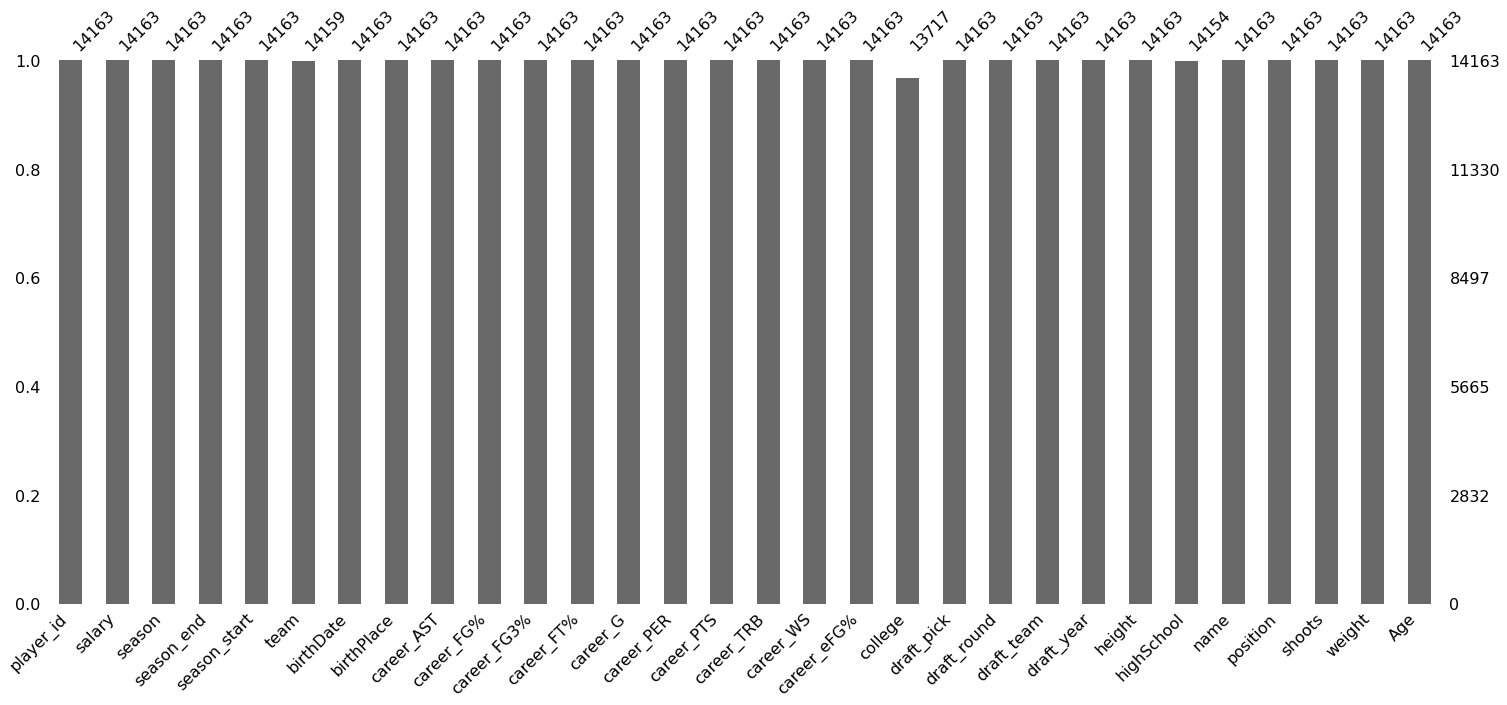

In [30]:
## taking a look at our missing values
msno.bar(player_salaries_df)

In [31]:
## since our id is our primary key, let us drop name
player_salaries_df.drop(columns = ['name'], inplace = True)

In [32]:
player_salaries_df.head()

,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,position,shoots,weight,Age
0,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,240lb,22
1,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,240lb,23
2,abdelal01,500000,1992-93,1993,1992,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,240lb,24
3,abdelal01,805000,1993-94,1994,1993,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,240lb,25
4,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,4.8,50.2,Duke University,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,240lb,26


In [33]:
player_salaries_df.dtypes

player_id        object
salary            int64
season           object
season_end        int64
season_start      int64
team             object
birthDate        object
birthPlace       object
career_AST      float64
career_FG%       object
career_FG3%      object
career_FT%       object
career_G          int64
career_PER       object
career_PTS      float64
career_TRB       object
career_WS        object
career_eFG%      object
college          object
draft_pick       object
draft_round      object
draft_team       object
draft_year       object
height           object
highSchool       object
position         object
shoots           object
weight           object
Age               int64
dtype: object

In [34]:
import numpy as np
player_salaries_df['weight'] = player_salaries_df.weight.apply(lambda x: x[:-2]).astype(int)
player_salaries_df['height'] = player_salaries_df.height.apply(lambda x: int(x[0])*12 + int(x[2:]))
player_salaries_df.rename(columns = {'weight': 'weight (lbs)', 'height': 'height (inches)', 'career_G': 'career_games'})
player_salaries_df[['career_FG%', 'career_FG3%' , 'career_FT%', 'career_PER', 'career_TRB', 'career_WS', 'career_eFG%']] = player_salaries_df[['career_FG%', 'career_FG3%' , 'career_FT%', 'career_PER', 'career_TRB', 'career_WS', 'career_eFG%']].replace({'-' : np.nan})
player_salaries_df[['career_FG%', 'career_FG3%' , 'career_FT%', 'career_PER', 'career_TRB', 'career_WS', 'career_eFG%']] = player_salaries_df[['career_FG%', 'career_FG3%' , 'career_FT%', 'career_PER', 'career_TRB', 'career_WS', 'career_eFG%']].astype(float)
player_salaries_df[['season_end', 'season_start']] = player_salaries_df[['season_end', 'season_start']].astype(str)

In [35]:
player_salaries_df.dtypes

player_id        object
salary            int64
season           object
season_end       object
season_start     object
team             object
birthDate        object
birthPlace       object
career_AST      float64
career_FG%      float64
career_FG3%     float64
career_FT%      float64
career_G          int64
career_PER      float64
career_PTS      float64
career_TRB      float64
career_WS       float64
career_eFG%     float64
college          object
draft_pick       object
draft_round      object
draft_team       object
draft_year       object
height            int64
highSchool       object
position         object
shoots           object
weight            int64
Age               int64
dtype: object

In [36]:
from sklearn.preprocessing import MinMaxScaler
num_cols = list(player_salaries_df._get_numeric_data().columns)
num_cols.remove('salary')
scaler = scaler = MinMaxScaler()
player_salaries_df[num_cols]= pd.DataFrame(scaler.fit_transform(player_salaries_df[num_cols]))
player_salaries_df.head()

,player_id,salary,season,season_end,season_start,team,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,position,shoots,weight,Age
0,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.026786,0.502,0.0,0.701,0.158385,0.449963,0.189369,0.240876,0.027164,0.334667,Duke University,25th overall,1st round,Portland Trail Blazers,1990,0.678571,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,0.471366,0.153846
1,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,"June 24, 1968","Cairo, Egypt",0.026786,0.502,0.0,0.701,0.158385,0.449963,0.189369,0.240876,0.027164,0.334667,Duke University,25th overall,1st round,Portland Trail Blazers,1990,0.678571,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,0.471366,0.192308
2,abdelal01,500000,1992-93,1993,1992,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.026786,0.502,0.0,0.701,0.158385,0.449963,0.189369,0.240876,0.027164,0.334667,Duke University,25th overall,1st round,Portland Trail Blazers,1990,0.678571,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,0.471366,0.230769
3,abdelal01,805000,1993-94,1994,1993,Boston Celtics,"June 24, 1968","Cairo, Egypt",0.026786,0.502,0.0,0.701,0.158385,0.449963,0.189369,0.240876,0.027164,0.334667,Duke University,25th overall,1st round,Portland Trail Blazers,1990,0.678571,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,0.471366,0.269231
4,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,"June 24, 1968","Cairo, Egypt",0.026786,0.502,0.0,0.701,0.158385,0.449963,0.189369,0.240876,0.027164,0.334667,Duke University,25th overall,1st round,Portland Trail Blazers,1990,0.678571,"Bloomfield in Bloomfield, New Jersey",Power Forward,Right,0.471366,0.307692


In [37]:
player_salaries_df.to_csv('player_salaries.csv')